# Polystyrene Mastercurve (Oscillation)

Fit polystyrene mastercurve data with GM and fractional models.

**Data:** examples/data/pyRheo/polystyrene/master_curve_ps_oscillation_data.csv


In [1]:
# Google Colab compatibility - uncomment if running in Colab
# !pip install -q rheojax
# from google.colab import drive
# drive.mount('/content/drive')


## Setup and Imports

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
%matplotlib inline

import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fractional_maxwell_model import FractionalMaxwellModel
from rheojax.models.generalized_maxwell import GeneralizedMaxwell
from rheojax.models.herschel_bulkley import HerschelBulkley
from rheojax.pipeline.base import Pipeline
from rheojax.transforms.mastercurve import Mastercurve

jax, jnp = safe_import_jax()
verify_float64()
np.set_printoptions(precision=4, suppress=True)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore', category=RuntimeWarning)

def r2_complex(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
    ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot)

def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean(np.abs(y_true - y_pred) / np.maximum(np.abs(y_true), 1e-12)) * 100)
import arviz as az


INFO:2025-12-07 17:27:44,417:jax._src.xla_bridge:808: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Loading rheojax version 0.4.0


/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/piblin_jax/__init__.py:28: UserWarning: GPU acceleration is only available on Linux with CUDA 12+. Using JAX in CPU mode.
  from . import backend, data, dataio, transform


Found 'auto' as default backend, checking available backends


Matplotlib is available, defining as default backend


arviz_base available, exposing its functions as part of arviz.preview


arviz_stats available, exposing its functions as part of arviz.preview


arviz_plots available, exposing its functions as part of arviz.preview


## Load mastercurve data

In [3]:
DATA_DIR = Path.cwd().parent / 'data' / 'pyRheo' / 'polystyrene'
df = pd.read_csv(DATA_DIR / 'master_curve_ps_oscillation_data.csv')
omega = df['Angular Frequency'].to_numpy()
Gp = df['Storage Modulus'].to_numpy()
Gpp = df['Loss Modulus'].to_numpy()
G_star = Gp + 1j*Gpp


## Fit models

In [4]:
gm = GeneralizedMaxwell(n_modes=6, modulus_type='tensile')
gm.fit(omega, G_star, test_mode='oscillation', use_log_residuals=True)
gm_pred_components = gm.predict(omega)
gm_pred = gm_pred_components[:,0] + 1j*gm_pred_components[:,1]
gm_r2 = r2_complex(G_star, gm_pred)

fm = FractionalMaxwellModel()
fm.fit(omega, G_star, test_mode='oscillation', use_log_residuals=True)
fm_pred = fm.predict(omega, test_mode='oscillation')
fm_r2 = r2_complex(G_star, fm_pred)

print({'gm_r2': gm_r2, 'fm_r2': fm_r2})


Starting least squares optimization | {'method': 'trf', 'n_params': 13, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 1.453393s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=48 | final_cost=1.880866e+10 | time=1.453s | final_gradient_norm=2.5879054481782115e+17


Starting least squares optimization | {'method': 'trf', 'n_params': 13, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.427767s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=48 | final_cost=1.880866e+10 | time=0.428s | final_gradient_norm=2.5879054481782115e+17


Starting least squares optimization | {'method': 'trf', 'n_params': 11, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 1.066753s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=31 | final_cost=3.937492e+10 | time=1.067s | final_gradient_norm=2.0200867654136484e+16


Element minimization: early termination at n_modes=5 (R²=0.999301 < threshold=0.999499)


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 1.222147s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=30 | final_cost=7.099389e+00 | time=1.222s | final_gradient_norm=0.0065040219009454515


{'gm_r2': 0.9996658404204724, 'fm_r2': 0.28487891403164967}


## Plot fits

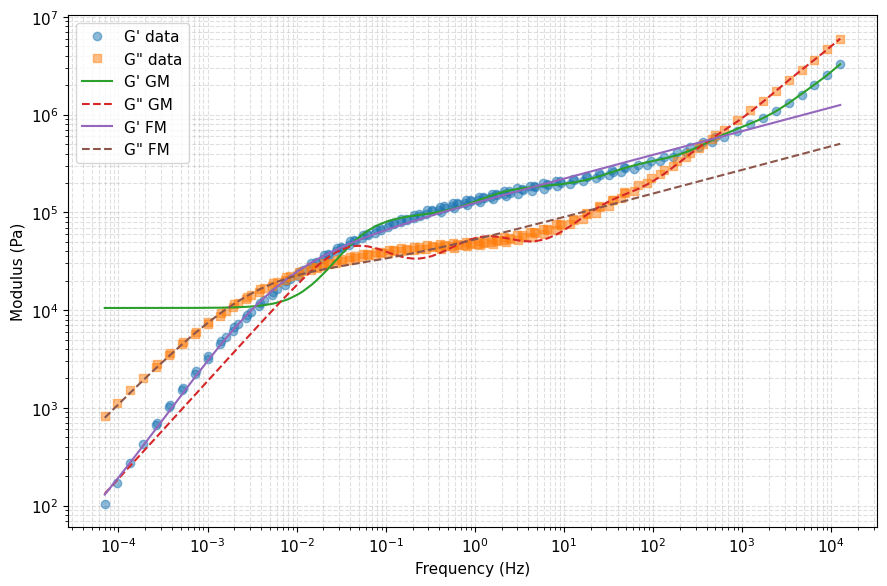

In [5]:
freq_hz = omega/(2*np.pi)
fig, ax = plt.subplots(figsize=(9,6))
ax.loglog(freq_hz, np.real(G_star), 'o', label="G' data", alpha=0.5)
ax.loglog(freq_hz, np.imag(G_star), 's', label='G" data', alpha=0.5)
ax.loglog(freq_hz, np.real(gm_pred), '-', label="G' GM")
ax.loglog(freq_hz, np.imag(gm_pred), '--', label='G" GM')
ax.loglog(freq_hz, np.real(fm_pred), '-', label="G' FM")
ax.loglog(freq_hz, np.imag(fm_pred), '--', label='G" FM')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Modulus (Pa)')
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.legend()
plt.tight_layout()
display(fig)
plt.close(fig)

## Bayesian workflow (NLSQ → best model → NUTS diagnostics)

Starting least squares optimization | {'method': 'trf', 'n_params': 13, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.430605s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=48 | final_cost=1.880866e+10 | time=0.431s | final_gradient_norm=2.5879054481782115e+17


Starting least squares optimization | {'method': 'trf', 'n_params': 13, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.425504s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=48 | final_cost=1.880866e+10 | time=0.426s | final_gradient_norm=2.5879054481782115e+17


Starting least squares optimization | {'method': 'trf', 'n_params': 11, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.355923s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=31 | final_cost=3.937492e+10 | time=0.356s | final_gradient_norm=2.0200867654136484e+16


Element minimization: early termination at n_modes=5 (R²=0.999301 < threshold=0.999499)


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.334342s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=30 | final_cost=7.099389e+00 | time=0.334s | final_gradient_norm=0.0065040219009454515


Model ranking (R²): [('gm', 1.0), ('fm', 0.285)]


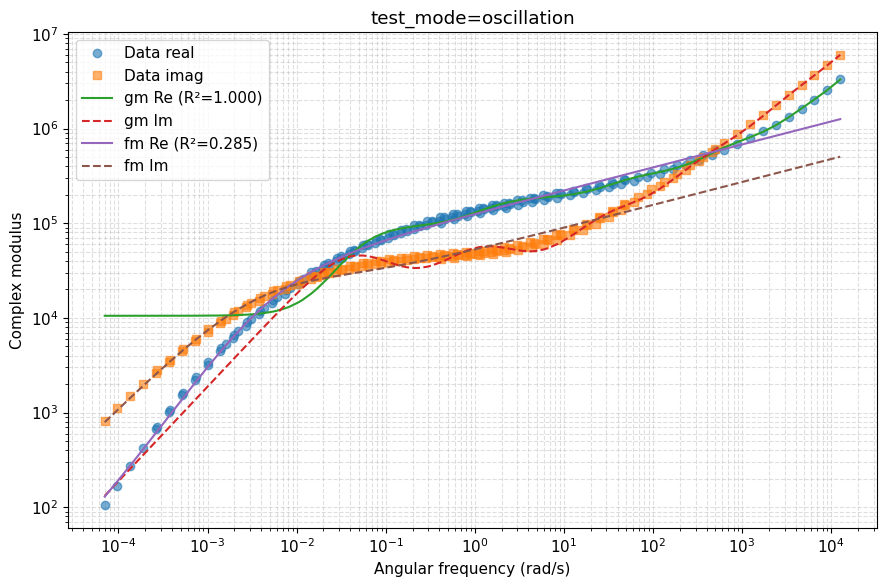

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   0%|          | 1/4000 [00:01<1:07:17,  1.01s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|          | 27/4000 [00:01<02:01, 32.82it/s, 511 steps of size 1.16e-02. acc. prob=0.71]

warmup:   1%|          | 42/4000 [00:01<01:19, 49.96it/s, 255 steps of size 1.14e-02. acc. prob=0.74]

warmup:   1%|▏         | 57/4000 [00:01<01:00, 65.49it/s, 511 steps of size 1.36e-02. acc. prob=0.75]

warmup:   2%|▏         | 71/4000 [00:01<00:53, 73.43it/s, 13 steps of size 4.88e-03. acc. prob=0.75] 

warmup:   2%|▏         | 84/4000 [00:01<00:47, 82.08it/s, 511 steps of size 1.27e-02. acc. prob=0.76]

warmup:   3%|▎         | 105/4000 [00:01<00:35, 109.66it/s, 127 steps of size 1.14e-01. acc. prob=0.76]

warmup:   5%|▍         | 188/4000 [00:01<00:13, 279.55it/s, 127 steps of size 7.86e-02. acc. prob=0.77]

warmup:   7%|▋         | 288/4000 [00:01<00:08, 461.31it/s, 15 steps of size 2.79e-01. acc. prob=0.78] 

warmup:  10%|▉         | 382/4000 [00:02<00:06, 587.88it/s, 15 steps of size 2.19e-01. acc. prob=0.78]

warmup:  12%|█▏        | 491/4000 [00:02<00:04, 725.54it/s, 127 steps of size 1.27e-01. acc. prob=0.79]

warmup:  15%|█▌        | 606/4000 [00:02<00:04, 844.85it/s, 31 steps of size 2.35e-01. acc. prob=0.79] 

warmup:  18%|█▊        | 729/4000 [00:02<00:03, 952.00it/s, 63 steps of size 1.22e-01. acc. prob=0.79]

warmup:  21%|██        | 846/4000 [00:02<00:03, 1015.16it/s, 15 steps of size 2.55e-01. acc. prob=0.79]

warmup:  24%|██▍       | 961/4000 [00:02<00:02, 1052.68it/s, 31 steps of size 2.14e-01. acc. prob=0.79]

sample:  27%|██▋       | 1080/4000 [00:02<00:02, 1092.49it/s, 31 steps of size 1.67e-01. acc. prob=0.90]

sample:  30%|██▉       | 1198/4000 [00:02<00:02, 1117.59it/s, 31 steps of size 1.67e-01. acc. prob=0.90]

sample:  33%|███▎      | 1319/4000 [00:02<00:02, 1144.96it/s, 31 steps of size 1.67e-01. acc. prob=0.90]

sample:  36%|███▌      | 1435/4000 [00:02<00:02, 1138.55it/s, 31 steps of size 1.67e-01. acc. prob=0.91]

sample:  39%|███▉      | 1552/4000 [00:03<00:02, 1146.20it/s, 31 steps of size 1.67e-01. acc. prob=0.91]

sample:  42%|████▏     | 1668/4000 [00:03<00:02, 1138.33it/s, 15 steps of size 1.67e-01. acc. prob=0.91]

sample:  45%|████▍     | 1789/4000 [00:03<00:01, 1158.17it/s, 15 steps of size 1.67e-01. acc. prob=0.91]

sample:  48%|████▊     | 1906/4000 [00:03<00:01, 1149.38it/s, 31 steps of size 1.67e-01. acc. prob=0.91]

sample:  51%|█████     | 2025/4000 [00:03<00:01, 1159.51it/s, 15 steps of size 1.67e-01. acc. prob=0.90]

sample:  54%|█████▎    | 2142/4000 [00:03<00:01, 1155.55it/s, 31 steps of size 1.67e-01. acc. prob=0.90]

sample:  57%|█████▋    | 2261/4000 [00:03<00:01, 1164.44it/s, 15 steps of size 1.67e-01. acc. prob=0.90]

sample:  59%|█████▉    | 2378/4000 [00:03<00:01, 1153.06it/s, 31 steps of size 1.67e-01. acc. prob=0.90]

sample:  62%|██████▏   | 2496/4000 [00:03<00:01, 1157.79it/s, 31 steps of size 1.67e-01. acc. prob=0.90]

sample:  65%|██████▌   | 2612/4000 [00:03<00:01, 1146.40it/s, 31 steps of size 1.67e-01. acc. prob=0.90]

sample:  68%|██████▊   | 2728/4000 [00:04<00:01, 1149.69it/s, 15 steps of size 1.67e-01. acc. prob=0.90]

sample:  71%|███████   | 2844/4000 [00:04<00:01, 1146.28it/s, 31 steps of size 1.67e-01. acc. prob=0.90]

sample:  74%|███████▍  | 2963/4000 [00:04<00:00, 1157.32it/s, 31 steps of size 1.67e-01. acc. prob=0.90]

sample:  77%|███████▋  | 3079/4000 [00:04<00:00, 1155.63it/s, 15 steps of size 1.67e-01. acc. prob=0.90]

sample:  80%|███████▉  | 3198/4000 [00:04<00:00, 1162.85it/s, 31 steps of size 1.67e-01. acc. prob=0.90]

sample:  83%|████████▎ | 3315/4000 [00:04<00:00, 1157.10it/s, 7 steps of size 1.67e-01. acc. prob=0.90] 

sample:  86%|████████▌ | 3431/4000 [00:04<00:00, 1157.11it/s, 31 steps of size 1.67e-01. acc. prob=0.90]

sample:  89%|████████▊ | 3548/4000 [00:04<00:00, 1160.25it/s, 15 steps of size 1.67e-01. acc. prob=0.90]

sample:  92%|█████████▏| 3665/4000 [00:04<00:00, 1154.08it/s, 15 steps of size 1.67e-01. acc. prob=0.90]

sample:  95%|█████████▍| 3781/4000 [00:04<00:00, 1150.19it/s, 31 steps of size 1.67e-01. acc. prob=0.90]

sample:  97%|█████████▋| 3897/4000 [00:05<00:00, 1148.09it/s, 15 steps of size 1.67e-01. acc. prob=0.90]

sample: 100%|██████████| 4000/4000 [00:05<00:00, 779.43it/s, 31 steps of size 1.67e-01. acc. prob=0.90] 

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   1%|          | 24/4000 [00:00<00:17, 224.65it/s, 1023 steps of size 8.02e-03. acc. prob=0.70]

warmup:   1%|          | 47/4000 [00:00<00:30, 128.28it/s, 383 steps of size 1.58e-02. acc. prob=0.74] 

warmup:   2%|▏         | 62/4000 [00:00<00:29, 132.83it/s, 767 steps of size 5.58e-03. acc. prob=0.74]

warmup:   2%|▏         | 78/4000 [00:00<00:28, 137.35it/s, 511 steps of size 1.13e-02. acc. prob=0.76]

warmup:   2%|▏         | 93/4000 [00:00<00:29, 132.75it/s, 95 steps of size 7.84e-03. acc. prob=0.76] 

warmup:   3%|▎         | 119/4000 [00:00<00:22, 169.16it/s, 31 steps of size 2.82e-01. acc. prob=0.77]

warmup:   5%|▍         | 190/4000 [00:00<00:11, 325.74it/s, 15 steps of size 3.59e-01. acc. prob=0.78]

warmup:   7%|▋         | 293/4000 [00:00<00:06, 529.81it/s, 63 steps of size 9.29e-02. acc. prob=0.78]

warmup:  10%|▉         | 397/4000 [00:01<00:05, 678.73it/s, 63 steps of size 1.49e-01. acc. prob=0.78]

warmup:  13%|█▎        | 502/4000 [00:01<00:04, 786.14it/s, 31 steps of size 1.62e-01. acc. prob=0.78]

warmup:  15%|█▌        | 602/4000 [00:01<00:04, 848.36it/s, 31 steps of size 1.91e-01. acc. prob=0.79]

warmup:  18%|█▊        | 727/4000 [00:01<00:03, 966.59it/s, 31 steps of size 2.28e-01. acc. prob=0.79]

warmup:  21%|██▏       | 851/4000 [00:01<00:03, 1047.64it/s, 31 steps of size 2.36e-01. acc. prob=0.79]

warmup:  24%|██▍       | 966/4000 [00:01<00:02, 1076.85it/s, 31 steps of size 2.39e-01. acc. prob=0.79]

sample:  27%|██▋       | 1075/4000 [00:01<00:02, 1059.21it/s, 31 steps of size 1.53e-01. acc. prob=0.91]

sample:  30%|██▉       | 1183/4000 [00:01<00:02, 1064.79it/s, 31 steps of size 1.53e-01. acc. prob=0.89]

sample:  32%|███▏      | 1290/4000 [00:01<00:02, 1055.89it/s, 15 steps of size 1.53e-01. acc. prob=0.90]

sample:  35%|███▍      | 1398/4000 [00:01<00:02, 1060.27it/s, 31 steps of size 1.53e-01. acc. prob=0.91]

sample:  38%|███▊      | 1505/4000 [00:02<00:02, 1058.86it/s, 31 steps of size 1.53e-01. acc. prob=0.91]

sample:  40%|████      | 1612/4000 [00:02<00:02, 1060.98it/s, 31 steps of size 1.53e-01. acc. prob=0.91]

sample:  43%|████▎     | 1719/4000 [00:02<00:02, 1052.78it/s, 15 steps of size 1.53e-01. acc. prob=0.91]

sample:  46%|████▌     | 1828/4000 [00:02<00:02, 1060.39it/s, 31 steps of size 1.53e-01. acc. prob=0.91]

sample:  48%|████▊     | 1935/4000 [00:02<00:01, 1049.60it/s, 31 steps of size 1.53e-01. acc. prob=0.91]

sample:  51%|█████     | 2041/4000 [00:02<00:01, 1046.40it/s, 15 steps of size 1.53e-01. acc. prob=0.91]

sample:  54%|█████▍    | 2152/4000 [00:02<00:01, 1062.14it/s, 31 steps of size 1.53e-01. acc. prob=0.91]

sample:  56%|█████▋    | 2260/4000 [00:02<00:01, 1065.59it/s, 31 steps of size 1.53e-01. acc. prob=0.92]

sample:  59%|█████▉    | 2368/4000 [00:02<00:01, 1068.33it/s, 31 steps of size 1.53e-01. acc. prob=0.92]

sample:  62%|██████▏   | 2475/4000 [00:03<00:01, 1062.17it/s, 31 steps of size 1.53e-01. acc. prob=0.92]

sample:  65%|██████▍   | 2582/4000 [00:03<00:01, 1053.25it/s, 31 steps of size 1.53e-01. acc. prob=0.92]

sample:  67%|██████▋   | 2694/4000 [00:03<00:01, 1070.96it/s, 31 steps of size 1.53e-01. acc. prob=0.91]

sample:  70%|███████   | 2802/4000 [00:03<00:01, 1069.73it/s, 31 steps of size 1.53e-01. acc. prob=0.92]

sample:  73%|███████▎  | 2909/4000 [00:03<00:01, 1056.41it/s, 15 steps of size 1.53e-01. acc. prob=0.92]

sample:  75%|███████▌  | 3019/4000 [00:03<00:00, 1067.30it/s, 63 steps of size 1.53e-01. acc. prob=0.92]

sample:  78%|███████▊  | 3126/4000 [00:03<00:00, 1063.08it/s, 31 steps of size 1.53e-01. acc. prob=0.92]

sample:  81%|████████  | 3233/4000 [00:03<00:00, 1053.19it/s, 31 steps of size 1.53e-01. acc. prob=0.90]

sample:  84%|████████▎ | 3342/4000 [00:03<00:00, 1061.53it/s, 31 steps of size 1.53e-01. acc. prob=0.91]

sample:  86%|████████▋ | 3450/4000 [00:03<00:00, 1066.78it/s, 31 steps of size 1.53e-01. acc. prob=0.91]

sample:  89%|████████▉ | 3557/4000 [00:04<00:00, 1058.71it/s, 31 steps of size 1.53e-01. acc. prob=0.91]

sample:  92%|█████████▏| 3663/4000 [00:04<00:00, 1053.18it/s, 31 steps of size 1.53e-01. acc. prob=0.91]

sample:  94%|█████████▍| 3769/4000 [00:04<00:00, 1052.79it/s, 31 steps of size 1.53e-01. acc. prob=0.91]

sample:  97%|█████████▋| 3877/4000 [00:04<00:00, 1058.11it/s, 31 steps of size 1.53e-01. acc. prob=0.91]

sample: 100%|█████████▉| 3983/4000 [00:04<00:00, 1057.77it/s, 31 steps of size 1.53e-01. acc. prob=0.91]

sample: 100%|██████████| 4000/4000 [00:04<00:00, 898.56it/s, 31 steps of size 1.53e-01. acc. prob=0.91] 

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   1%|          | 29/4000 [00:00<00:15, 261.06it/s, 831 steps of size 4.43e-03. acc. prob=0.70]

warmup:   1%|▏         | 56/4000 [00:00<00:31, 125.24it/s, 255 steps of size 1.32e-02. acc. prob=0.75]

warmup:   2%|▏         | 73/4000 [00:00<00:34, 115.35it/s, 511 steps of size 1.18e-02. acc. prob=0.76]

warmup:   2%|▏         | 87/4000 [00:00<00:36, 108.33it/s, 255 steps of size 1.30e-02. acc. prob=0.76]

warmup:   2%|▏         | 99/4000 [00:00<00:37, 105.02it/s, 479 steps of size 1.83e-02. acc. prob=0.77]

warmup:   5%|▍         | 183/4000 [00:00<00:13, 284.56it/s, 31 steps of size 5.30e-02. acc. prob=0.77]

warmup:   7%|▋         | 287/4000 [00:01<00:07, 479.23it/s, 31 steps of size 3.06e-01. acc. prob=0.78]

warmup:  10%|▉         | 397/4000 [00:01<00:05, 645.84it/s, 15 steps of size 2.85e-01. acc. prob=0.78]

warmup:  13%|█▎        | 508/4000 [00:01<00:04, 768.02it/s, 127 steps of size 6.42e-02. acc. prob=0.78]

warmup:  15%|█▌        | 600/4000 [00:01<00:04, 808.66it/s, 63 steps of size 8.96e-02. acc. prob=0.79] 

warmup:  18%|█▊        | 728/4000 [00:01<00:03, 943.45it/s, 15 steps of size 1.75e-01. acc. prob=0.79]

warmup:  21%|██        | 847/4000 [00:01<00:03, 1014.17it/s, 31 steps of size 1.74e-01. acc. prob=0.79]

warmup:  24%|██▍       | 976/4000 [00:01<00:02, 1086.32it/s, 127 steps of size 8.16e-02. acc. prob=0.79]

sample:  27%|██▋       | 1088/4000 [00:01<00:02, 1060.15it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  30%|██▉       | 1197/4000 [00:01<00:02, 1058.70it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  33%|███▎      | 1305/4000 [00:01<00:02, 1052.56it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  35%|███▌      | 1412/4000 [00:02<00:02, 1041.10it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  38%|███▊      | 1517/4000 [00:02<00:02, 987.25it/s, 31 steps of size 1.34e-01. acc. prob=0.93] 

sample:  41%|████      | 1622/4000 [00:02<00:02, 1004.16it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  43%|████▎     | 1729/4000 [00:02<00:02, 1020.70it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  46%|████▌     | 1832/4000 [00:02<00:02, 1017.93it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  48%|████▊     | 1935/4000 [00:02<00:02, 1019.54it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  51%|█████     | 2038/4000 [00:02<00:01, 1022.23it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  54%|█████▎    | 2141/4000 [00:02<00:01, 1021.54it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  56%|█████▌    | 2244/4000 [00:02<00:01, 1011.45it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  59%|█████▊    | 2348/4000 [00:03<00:01, 1017.48it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  61%|██████▏   | 2456/4000 [00:03<00:01, 1033.42it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  64%|██████▍   | 2560/4000 [00:03<00:01, 1023.76it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  67%|██████▋   | 2663/4000 [00:03<00:01, 1024.49it/s, 15 steps of size 1.34e-01. acc. prob=0.93]

sample:  69%|██████▉   | 2768/4000 [00:03<00:01, 1029.10it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  72%|███████▏  | 2872/4000 [00:03<00:01, 1031.96it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  74%|███████▍  | 2978/4000 [00:03<00:00, 1039.92it/s, 15 steps of size 1.34e-01. acc. prob=0.93]

sample:  77%|███████▋  | 3083/4000 [00:03<00:00, 1041.59it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  80%|███████▉  | 3188/4000 [00:03<00:00, 1043.83it/s, 31 steps of size 1.34e-01. acc. prob=0.94]

sample:  82%|████████▏ | 3293/4000 [00:03<00:00, 1041.01it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  85%|████████▍ | 3398/4000 [00:04<00:00, 1036.31it/s, 31 steps of size 1.34e-01. acc. prob=0.93]

sample:  88%|████████▊ | 3502/4000 [00:04<00:00, 1034.99it/s, 15 steps of size 1.34e-01. acc. prob=0.94]

sample:  90%|█████████ | 3607/4000 [00:04<00:00, 1037.62it/s, 31 steps of size 1.34e-01. acc. prob=0.94]

sample:  93%|█████████▎| 3712/4000 [00:04<00:00, 1039.43it/s, 31 steps of size 1.34e-01. acc. prob=0.94]

sample:  95%|█████████▌| 3816/4000 [00:04<00:00, 1028.76it/s, 41 steps of size 1.34e-01. acc. prob=0.94]

sample:  98%|█████████▊| 3922/4000 [00:04<00:00, 1037.59it/s, 31 steps of size 1.34e-01. acc. prob=0.94]

sample: 100%|██████████| 4000/4000 [00:04<00:00, 868.27it/s, 31 steps of size 1.34e-01. acc. prob=0.94] 

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   1%|          | 36/4000 [00:00<00:11, 356.39it/s, 127 steps of size 1.23e-02. acc. prob=0.73]

warmup:   2%|▏         | 72/4000 [00:00<00:25, 153.75it/s, 511 steps of size 5.30e-03. acc. prob=0.75]

warmup:   2%|▏         | 94/4000 [00:00<00:25, 155.64it/s, 511 steps of size 4.78e-03. acc. prob=0.76]

warmup:   3%|▎         | 123/4000 [00:00<00:20, 189.89it/s, 63 steps of size 1.76e-01. acc. prob=0.77]

warmup:   5%|▌         | 216/4000 [00:00<00:09, 387.60it/s, 31 steps of size 1.88e-01. acc. prob=0.78]

warmup:   8%|▊         | 334/4000 [00:00<00:06, 606.30it/s, 15 steps of size 3.08e-01. acc. prob=0.78]

warmup:  12%|█▏        | 464/4000 [00:00<00:04, 802.15it/s, 63 steps of size 1.39e-01. acc. prob=0.78]

warmup:  14%|█▍        | 565/4000 [00:01<00:03, 861.46it/s, 15 steps of size 2.53e-01. acc. prob=0.79]

warmup:  17%|█▋        | 695/4000 [00:01<00:03, 985.94it/s, 31 steps of size 2.58e-01. acc. prob=0.79]

warmup:  20%|██        | 820/4000 [00:01<00:02, 1061.62it/s, 31 steps of size 2.04e-01. acc. prob=0.79]

warmup:  24%|██▎       | 948/4000 [00:01<00:02, 1122.74it/s, 31 steps of size 2.18e-01. acc. prob=0.79]

sample:  27%|██▋       | 1064/4000 [00:01<00:02, 1064.29it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  29%|██▉       | 1174/4000 [00:01<00:02, 1063.60it/s, 7 steps of size 1.56e-01. acc. prob=0.95] 

sample:  32%|███▏      | 1283/4000 [00:01<00:02, 1053.29it/s, 15 steps of size 1.56e-01. acc. prob=0.94]

sample:  35%|███▍      | 1392/4000 [00:01<00:02, 1060.86it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  38%|███▊      | 1500/4000 [00:01<00:02, 1059.23it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  40%|████      | 1607/4000 [00:02<00:02, 1055.38it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  43%|████▎     | 1716/4000 [00:02<00:02, 1065.02it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  46%|████▌     | 1823/4000 [00:02<00:02, 1044.14it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  48%|████▊     | 1928/4000 [00:02<00:01, 1038.54it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  51%|█████     | 2036/4000 [00:02<00:01, 1050.34it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  54%|█████▎    | 2142/4000 [00:02<00:01, 1039.52it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  56%|█████▌    | 2247/4000 [00:02<00:01, 1038.77it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  59%|█████▉    | 2354/4000 [00:02<00:01, 1046.42it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  62%|██████▏   | 2464/4000 [00:02<00:01, 1061.66it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  64%|██████▍   | 2571/4000 [00:02<00:01, 1042.17it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  67%|██████▋   | 2676/4000 [00:03<00:01, 1044.15it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  70%|██████▉   | 2781/4000 [00:03<00:01, 1045.26it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  72%|███████▏  | 2887/4000 [00:03<00:01, 1047.63it/s, 63 steps of size 1.56e-01. acc. prob=0.94]

sample:  75%|███████▍  | 2993/4000 [00:03<00:00, 1049.84it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  77%|███████▋  | 3099/4000 [00:03<00:00, 1049.10it/s, 15 steps of size 1.56e-01. acc. prob=0.94]

sample:  80%|████████  | 3204/4000 [00:03<00:00, 1047.43it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  83%|████████▎ | 3309/4000 [00:03<00:00, 1046.86it/s, 15 steps of size 1.56e-01. acc. prob=0.94]

sample:  85%|████████▌ | 3414/4000 [00:03<00:00, 974.93it/s, 31 steps of size 1.56e-01. acc. prob=0.94] 

sample:  88%|████████▊ | 3521/4000 [00:03<00:00, 1000.38it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  91%|█████████ | 3626/4000 [00:03<00:00, 1014.07it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  93%|█████████▎| 3732/4000 [00:04<00:00, 1026.85it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  96%|█████████▌| 3839/4000 [00:04<00:00, 1039.12it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample:  99%|█████████▊| 3946/4000 [00:04<00:00, 1047.06it/s, 31 steps of size 1.56e-01. acc. prob=0.94]

sample: 100%|██████████| 4000/4000 [00:04<00:00, 926.97it/s, 31 steps of size 1.56e-01. acc. prob=0.94] 

/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/arviz/plots/backends/matplotlib/pairplot.py:223: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


array([[<Axes: ylabel='E_2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_3'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_4'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_5'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_6'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_inf'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma_imag'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='E_1', ylabel='sigma_real'>, <Axes: xlabel='E_2'>,
        <Axes: xlabel='E_3'>, <Axes: xlabel='E_4'>, <Axes: xlabel='E_5'>,
        <Axes: xlabel='E_6'>, <Axes: xlabel='E_inf'>,
        <Axes: xlabel='sigm

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot due to: 'Dataset' object has no attribute 'energy'


/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (60) in plot_autocorr, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'E_1\n0'}>,
        <Axes: title={'center': 'E_1\n1'}>,
        <Axes: title={'center': 'E_1\n2'}>,
        <Axes: title={'center': 'E_1\n3'}>],
       [<Axes: title={'center': 'E_2\n0'}>,
        <Axes: title={'center': 'E_2\n1'}>,
        <Axes: title={'center': 'E_2\n2'}>,
        <Axes: title={'center': 'E_2\n3'}>],
       [<Axes: title={'center': 'E_3\n0'}>,
        <Axes: title={'center': 'E_3\n1'}>,
        <Axes: title={'center': 'E_3\n2'}>,
        <Axes: title={'center': 'E_3\n3'}>],
       [<Axes: title={'center': 'E_4\n0'}>,
        <Axes: title={'center': 'E_4\n1'}>,
        <Axes: title={'center': 'E_4\n2'}>,
        <Axes: title={'center': 'E_4\n3'}>],
       [<Axes: title={'center': 'E_5\n0'}>,
        <Axes: title={'center': 'E_5\n1'}>,
        <Axes: title={'center': 'E_5\n2'}>,
        <Axes: title={'center': 'E_5\n3'}>],
       [<Axes: title={'center': 'E_6\n0'}>,
        <Axes: title={'center': 'E_6\n1'}>,
        <Axes: title={'cent

array([[<Axes: title={'center': 'E_1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_3'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'E_4'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_5'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_6'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'E_inf'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'sigma_imag'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'sigma_real'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'tau_1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau_2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau_3'}, 

array([[<Axes: title={'center': 'E_1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_3'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'E_4'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_5'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_6'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'E_inf'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'sigma_imag'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'sigma_real'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'tau_1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau_2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title

In [6]:
# Unified workflow: load → NLSQ fits → best by R² → Bayesian → diagnostics

# Fallback R² for complex data
if 'r2_complex' not in globals():
    def r2_complex(y_true, y_pred):
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
        ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
        return 1 - ss_res / ss_tot



# Handle models that return real/imag columns instead of complex numbers
if '_coerce_pred' not in globals():
    def _coerce_pred(pred):
        arr = np.asarray(pred)
        if arr.ndim == 2 and arr.shape[1] == 2 and not np.iscomplexobj(arr):
            arr = arr[:, 0] + 1j * arr[:, 1]
        return arr


NUTS_CONFIG = dict(num_chains=4, num_warmup=1000, num_samples=3000)

def _detect_datasets():
    datasets = []
    if 'G_star' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': G_star,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    elif 'Gp' in globals() and 'Gpp' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': Gp + 1j * Gpp,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    if 'master' in globals() and hasattr(master, 'x') and hasattr(master, 'y'):
        datasets.append({
            'X': master.x,
            'y': master.y,
            'test_mode': master.metadata.get('test_mode', 'oscillation') if hasattr(master, 'metadata') else 'oscillation',
            'x_label': 'Shifted frequency',
            'y_label': 'Mastercurve modulus',
        })
    if 't' in globals() and 'G' in globals():
        datasets.append({
            'X': t,
            'y': G,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })

    if 't' in globals() and 'E_t' in globals():
        datasets.append({
            'X': t,
            'y': E_t,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })
    if 't' in globals() and 'sigma' in globals():
        datasets.append({
            'X': t,
            'y': sigma,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Stress (Pa)',
        })
    if 't' in globals() and 'J' in globals():
        datasets.append({
            'X': t,
            'y': J,
            'test_mode': 'creep',
            'x_label': 'Time (s)',
            'y_label': 'Creep compliance',
        })
    if 'all_df' in globals() and hasattr(all_df, 'columns') and 'phi' in all_df.columns:
        for phi, frame in all_df.groupby('phi'):
            x_vals = frame.iloc[:, 0].to_numpy()
            y_vals = frame.iloc[:, 1].to_numpy()
            datasets.append({
                'X': x_vals,
                'y': y_vals,
                'test_mode': 'rotation',
                'x_label': f'Shear rate 1/s (phi={phi})',
                'y_label': 'Stress (Pa)',
                'label': f'phi={phi}',
            })
    if not datasets:
        raise ValueError('No datasets detected; ensure data variables are defined before running this cell.')
    return datasets


def _collect_candidate_models():
    if 'candidates' in globals() and isinstance(candidates, (list, tuple)) and candidates:
        return candidates
    models = []
    for name, obj in globals().items():
        if isinstance(obj, type):
            continue  # skip classes; require initialized models
        if hasattr(obj, 'fit_bayesian') and hasattr(obj, 'predict'):
            models.append((name, obj))
    if not models:
        raise ValueError('No candidate models found; define models before running this cell.')
    return models


def _plot_data_and_fits(ds, fits):
    fig, ax = plt.subplots(figsize=(9, 6))
    X_plot = ds['X']
    y_true = ds['y']
    if np.iscomplexobj(y_true):
        x_axis = X_plot / (2 * np.pi) if ds['test_mode'] == 'oscillation' else X_plot
        ax.loglog(x_axis, np.real(y_true), 'o', label="Data real", alpha=0.6)
        ax.loglog(x_axis, np.imag(y_true), 's', label="Data imag", alpha=0.6)
        for rec in fits:
            pred = _coerce_pred(rec['pred'])
            ax.loglog(x_axis, np.real(pred), '-', label=f"{rec['name']} Re (R²={rec['r2']:.3f})")
            ax.loglog(x_axis, np.imag(pred), '--', label=f"{rec['name']} Im")
    else:
        x_axis = X_plot
        ax.loglog(x_axis, y_true, 'o', label='Data', alpha=0.6)
        for rec in fits:
            ax.loglog(x_axis, rec['pred'], '-', label=f"{rec['name']} (R²={rec['r2']:.3f})")
    ax.set_xlabel(ds.get('x_label', 'X'))
    ax.set_ylabel(ds.get('y_label', 'Response'))
    ax.set_title(ds.get('label', f"test_mode={ds['test_mode']}"))
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()
    plt.tight_layout()
    display(fig)
    plt.close(fig)


def _plot_diagnostics(idata):
    diag_plotters = [
        ('pair', lambda: az.plot_pair(idata, divergences=True, kind='kde')),
        ('forest', lambda: az.plot_forest(idata, combined=True)),
        ('energy', lambda: az.plot_energy(idata)),
        ('autocorr', lambda: az.plot_autocorr(idata)),
        ('rank', lambda: az.plot_rank(idata)),
        ('ess', lambda: az.plot_ess(idata, kind='evolution')),
    ]
    for name, plot_fn in diag_plotters:
        try:
            obj = plot_fn()
        except Exception as exc:
            print(f"Skipping {name} plot due to: {exc}")
            continue
        plt.tight_layout()
        display(obj)
        plt.close('all')


datasets = _detect_datasets()
model_entries = _collect_candidate_models()

for ds in datasets:
    fits = []
    for name, model in model_entries:
        fitted_model = model
        fit_kwargs = {'test_mode': ds['test_mode'], 'use_log_residuals': True}
        try:
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except TypeError:
            fit_kwargs.pop('use_log_residuals', None)
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except Exception as exc:
            print(f"Skipping {name} due to fit error: {exc}")
            continue
        predict_kwargs = {'test_mode': ds['test_mode']} if 'test_mode' in fit_kwargs else {}
        try:
            pred = _coerce_pred(fitted_model.predict(ds['X'], **predict_kwargs))
        except Exception as exc:
            print(f"Skipping {name} due to predict error: {exc}")
            continue
        try:
            r2_val = r2_complex(ds['y'], pred) if np.iscomplexobj(ds['y']) else fitted_model.score(ds['X'], ds['y'])
        except Exception as exc:
            print(f"Skipping {name} due to scoring error: {exc}")
            continue
        fits.append({'name': name, 'model': fitted_model, 'pred': pred, 'r2': float(r2_val)})

    if not fits:
        print('No successful fits for dataset; skipping Bayesian step.')
        continue

    fits.sort(key=lambda rec: rec['r2'], reverse=True)
    best = fits[0]
    print(f"Model ranking (R²): {[ (rec['name'], round(rec['r2'], 3)) for rec in fits ]}")
    _plot_data_and_fits(ds, fits)

    try:
        bayes_result = best['model'].fit_bayesian(
            ds['X'],
            ds['y'],
            **NUTS_CONFIG,
            test_mode=ds['test_mode'],
        )
        idata = bayes_result.to_inference_data()
        _plot_diagnostics(idata)
    except Exception as exc:
        print(f"Skipping Bayesian step for {best['name']} due to: {exc}")
